# Big Mart Sales Prediction

Here if we can predict the sales revenue, we can tell the company what are the challenges they may face, which brands and products are the favorite among customers etc. So this helps the sales team to understand which product to sell and promote and can also make several marketing plans

In [77]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [86]:
import io
big_mart_data = pd.read_csv(io.BytesIO(uploaded['Train.csv']))

In [87]:
big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [88]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [89]:
# getting information about the dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:

Item_Identifier

*   Item_Fat_Content
*   Item_Type
*   Outlet_Identifier
*   Outlet_Size
*   Outlet_Location_Type
*   Outlet_Type

In [90]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Handling the Missing values

In [91]:
# Calculating the mean of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [92]:
# replacing the null values in the "Item_Weight" column by the mean
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [93]:
# Calculating the mode of "Outlet_Size" column
big_mart_data['Outlet_Size'].mode()

0    Medium
dtype: object

In [94]:
# Filling the missing values in "Outlet_Size" column with Mode
# But here the outlet type column is correlated with outlet size column. So we have to find the mode based on outlet type
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [95]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [96]:
null_values = big_mart_data['Outlet_Size'].isnull()   

In [97]:
print(null_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [98]:
big_mart_data.loc[null_values, 'Outlet_Size'] = big_mart_data.loc[null_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [99]:
# re-checking for missing values again
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Data Analysis

In [100]:
# Statistical measuring of the data
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [101]:
sns.set()

EDA Numerical Features

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


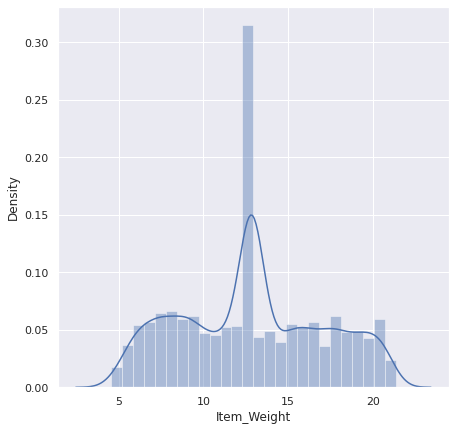

In [102]:
# Item_Weight distribution
plt.figure(figsize=(7,7))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


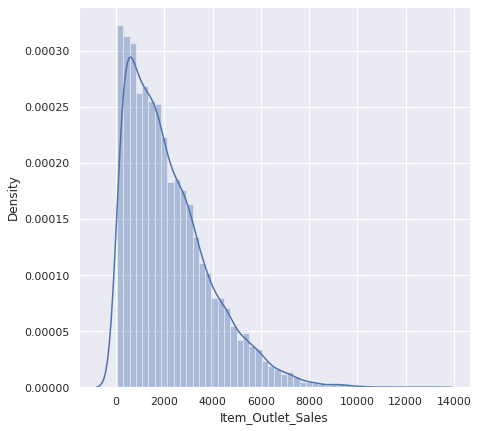

In [103]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(7,7))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


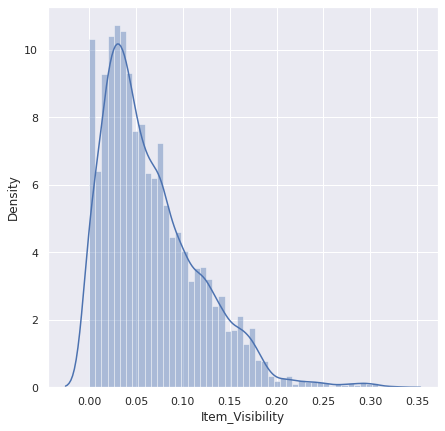

In [104]:
# Item Visibility distribution
plt.figure(figsize=(7,7))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

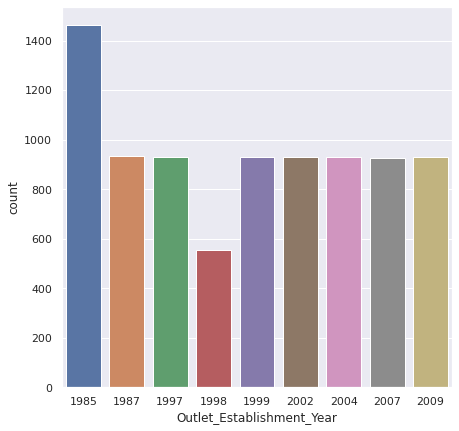

In [105]:
# Outlet_Establishment_Year column
plt.figure(figsize=(7,7))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


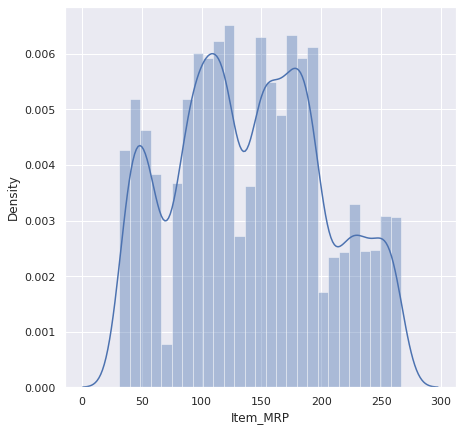

In [106]:
# Item MRP distribution
plt.figure(figsize=(7,7))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

EDA of categorical variables

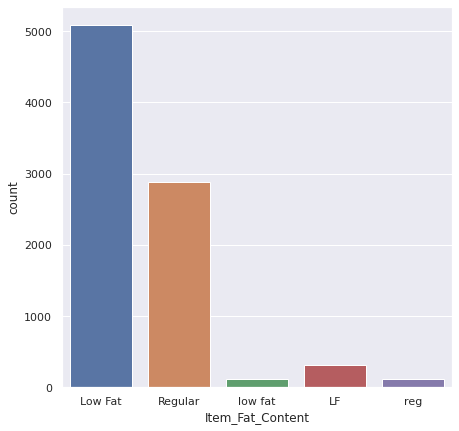

In [107]:
# Item_Fat_Content column
plt.figure(figsize=(7,7))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

In [108]:
# In this chart we can understand that Low Fat and low fat are the same but representing differently. So we have to sort this out

big_mart_data['Item_Fat_Content'] = big_mart_data['Item_Fat_Content'].replace({'low fat':'Low Fat','LF':'Low Fat'})

big_mart_data['Item_Fat_Content'] = big_mart_data['Item_Fat_Content'].replace({'reg':'Regular'})



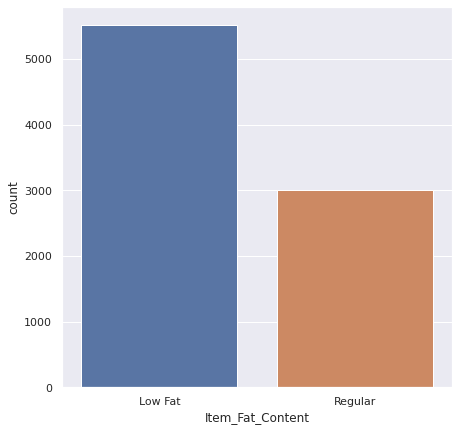

In [109]:
# Item_Fat_Content column
plt.figure(figsize=(7,7))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

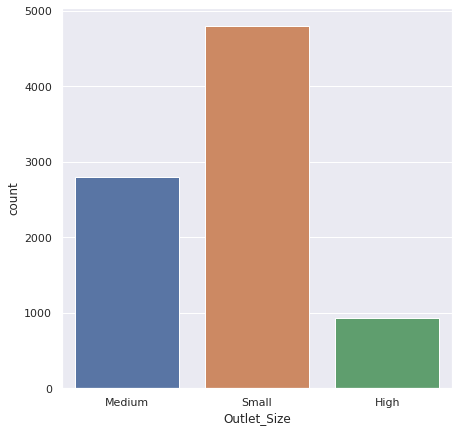

In [110]:
# Outlet_Size column
plt.figure(figsize=(7,7))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

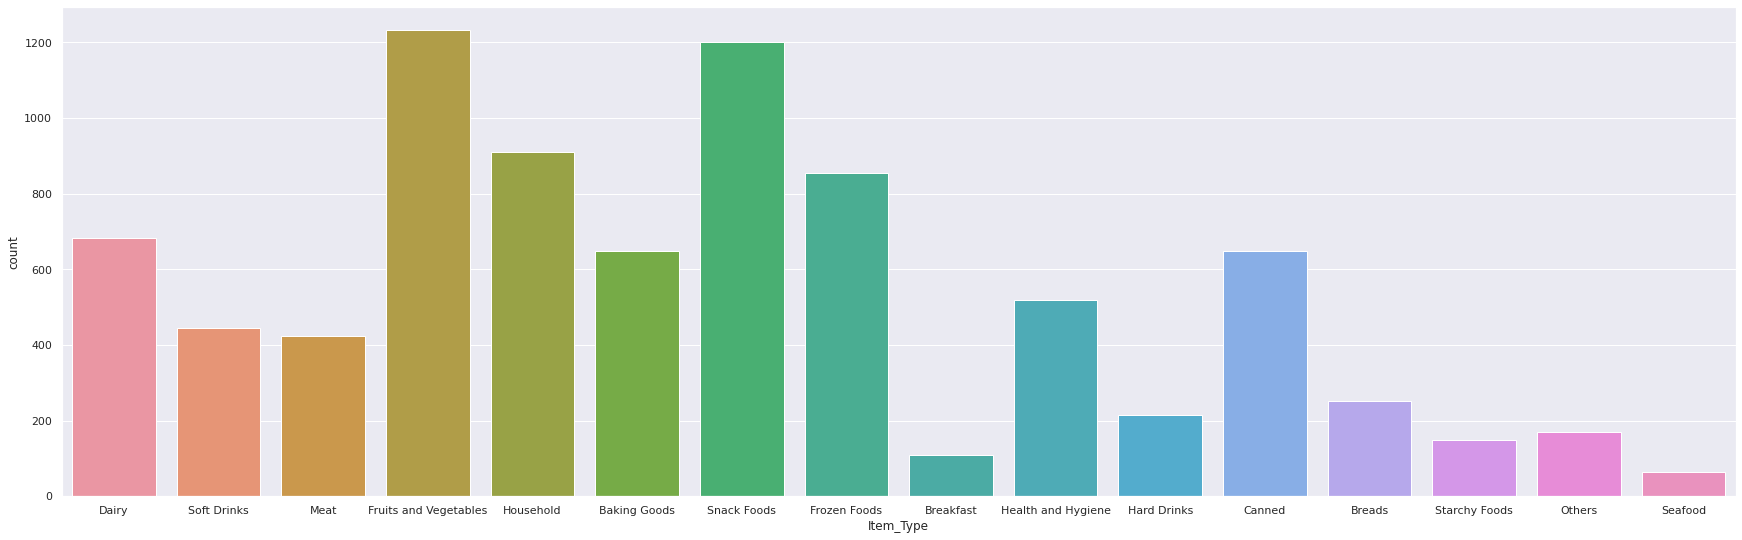

In [111]:
# Item_Type column
plt.figure(figsize=(30,9))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

## Data Pre-processing

Label Encoding

In [112]:
big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [113]:
Encode = LabelEncoder()

In [114]:
big_mart_data['Item_Identifier'] = Encode.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = Encode.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = Encode.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = Encode.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = Encode.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = Encode.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = Encode.fit_transform(big_mart_data['Outlet_Type'])

In [115]:
big_mart_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.930,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,370,6.865,0,0.056783,13,214.5218,1,1987,0,2,1,2778.3834
8519,897,8.380,1,0.046982,0,108.1570,7,2002,2,1,1,549.2850
8520,1357,10.600,0,0.035186,8,85.1224,6,2004,2,1,1,1193.1136
8521,681,7.210,1,0.145221,13,103.1332,3,2009,1,2,2,1845.5976


Splitting the data to X and y

In [116]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
y = big_mart_data['Item_Outlet_Sales']

Splitting into training and testing data

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


## Training the model

XG Boost regressor

In [119]:
regressor = XGBRegressor()

In [120]:
regressor.fit(X_train, y_train)

[15:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Evaluation

In [121]:
# prediction on training data
training_data_prediction_1 = regressor.predict(X_train)

In [122]:
# R squared Value
r2_train_1 = metrics.r2_score(y_train, training_data_prediction_1)

In [123]:
print('R Squared value = ', r2_train_1)

R Squared value =  0.6299244683485602


In [124]:
# prediction on test data
test_data_prediction_1 = regressor.predict(X_test)

In [125]:
# R squared Value
r2_test_1 = metrics.r2_score(y_test, test_data_prediction_1)

In [126]:
print('R Squared value = ', r2_test_1)

R Squared value =  0.604992657386936


Linear Regression

In [127]:
# Create an instance of the LinearRegression class
lin_reg = LinearRegression()

In [128]:
# Fit the model to the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [129]:
# prediction on training data
training_data_prediction_2 = lin_reg.predict(X_train)

In [130]:
# R squared Value
r2_train_2 = metrics.r2_score(y_train, training_data_prediction_2)

In [131]:
print('R Squared value = ', r2_train_2)

R Squared value =  0.49942172643737814


In [132]:
# prediction on test data
test_data_prediction_2 = regressor.predict(X_test)

In [133]:
# R squared Value
r2_test_2 = metrics.r2_score(y_test, test_data_prediction_2)

In [134]:
print('R Squared value = ', r2_test_2)

R Squared value =  0.604992657386936


From these its clear that XG Boost Regressor gives the best outcome in the model